In [2]:
pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 5.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 5.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 4.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 6.3 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 6.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 6.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 597.5 kB/s eta 0:00:0000:0100:04
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 KB 4.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 5.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
pip install streamlit

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
# First Cell: Importing necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from transformers import pipeline  # For using a pre-trained GPT model


/home/workbench/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Second Cell: Function to load data from yfinance
def load_data(ticker):
    stock_data = yf.Ticker(ticker)
    df = stock_data.history(period="max")
    # Feature Engineering
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['Daily_Returns'] = df['Close'].pct_change()
    df['Volatility'] = df['Daily_Returns'].rolling(window=30).std() * np.sqrt(30)
    df['Target'] = df['Close'].shift(-1)
    df.dropna(inplace=True)
    return df

# Test the function with a stock ticker
df = load_data("NVDA")
df.tail()


,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_20,SMA_50,RSI,Daily_Returns,Volatility,Target
Date,,,,,,,,,,,,,
2024-09-25 00:00:00-04:00,122.019997,124.940002,121.610001,123.510002,284692900,0.0,0.0,114.834718,115.711518,70.210424,0.021842,0.197155,124.040001
2024-09-26 00:00:00-04:00,126.800003,127.669998,121.800003,124.040001,302582900,0.0,0.0,114.756755,115.832720,79.067804,0.004291,0.196632,121.400002
2024-09-27 00:00:00-04:00,123.970001,124.029999,119.260002,121.400002,271009200,0.0,0.0,114.947758,115.839127,71.041529,-0.021283,0.193899,121.440002
2024-09-30 00:00:00-04:00,118.309998,121.500000,118.150002,121.440002,226553700,0.0,0.0,115.051768,115.909529,69.683790,0.000329,0.193375,117.000000
2024-10-01 00:00:00-04:00,121.769997,122.440002,115.790001,117.000000,300108800,0.0,0.0,115.502230,115.778940,50.169259,-0.036561,0.191201,119.055000


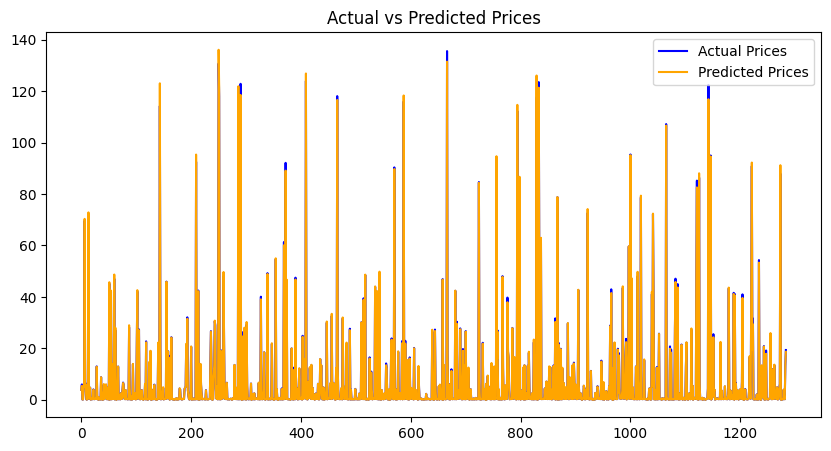

In [3]:
# Third Cell: Linear Regression Model for stock price prediction
X = df[['Close']]
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Plot Actual vs Predicted Prices
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual Prices', color='blue')
plt.plot(predictions, label='Predicted Prices', color='orange')
plt.legend()
plt.title('Actual vs Predicted Prices')
plt.show()


In [4]:
# Fourth Cell: Generative AI Model for stock report generation
# Load the pre-trained GPT model from Hugging Face
generative_model = pipeline('text-generation', model='gpt2')

# Define a prompt
summary_prompt = (
    f"The stock NVDA has recently shown the following trends:\n"
    f"- 20-day moving average: {df['SMA_20'].iloc[-1]:.2f}\n"
    f"- 50-day moving average: {df['SMA_50'].iloc[-1]:.2f}\n"
    f"- Relative Strength Index (RSI): {df['RSI'].iloc[-1]:.2f}\n"
    f"- Daily volatility: {df['Volatility'].iloc[-1]:.2f}\n"
    "Write a detailed report on the stock's performance and expected trends."
)

# Generate the report
report = generative_model(summary_prompt, max_length=300)[0]['generated_text']
print(report)


/home/workbench/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


The stock NVDA has recently shown the following trends:
- 20-day moving average: 115.50
- 50-day moving average: 115.78
- Relative Strength Index (RSI): 50.17
- Daily volatility: 0.19
Write a detailed report on the stock's performance and expected trends. Or do share it here via a comment below.
